# YouTube Recap

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import configparser

### Read the configuration file

In [12]:
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

### Read the data

In [15]:
path = config['PATH']['path']
df_search = pd.read_json(f"{path}/history/search-history.json")

In [16]:
df_search.head()

,header,title,titleUrl,time,products,activityControls
0,YouTube,Searched for home assistant docker cloud,https://www.youtube.com/results?search_query=h...,2022-12-30T19:54:55.108Z,[YouTube],[YouTube search history]
1,YouTube,Searched for home assistant docker,https://www.youtube.com/results?search_query=h...,2022-12-30T19:54:49.003Z,[YouTube],[YouTube search history]
2,YouTube,Searched for strangest places in game of thrones,https://www.youtube.com/results?search_query=s...,2022-12-30T09:21:54.192Z,[YouTube],[YouTube search history]
3,YouTube,Searched for home assistant docker mac,https://www.youtube.com/results?search_query=h...,2022-12-30T07:20:07.337Z,[YouTube],[YouTube search history]
4,YouTube,Searched for home assistant docker,https://www.youtube.com/results?search_query=h...,2022-12-30T07:19:52.519Z,[YouTube],[YouTube search history]


# Search History

## Clean the data

#### drop unnecessary columns

In [17]:
df_search_clean = df_search.drop(['header', 'titleUrl', 'activityControls', 'products'], axis=1)

#### create a column for each search phrase

- create a column with only the search phrase
- create a function that removes first X words of the  

In [18]:
def remove_words(string, x):
    # split the string into a list of words
    words = string.split()
    
    # remove the first two words
    words = words[x:]
    
    # combine the remaining words into a new string
    new_string = " ".join(words)
    
    # return the new string
    return new_string


- remove the "searched for" before each search phrase in title

In [19]:
df_search_clean['phrase'] = df_search_clean['title'].apply(remove_words, x=2)

- drop title column

In [20]:
df_search_clean.drop(['title'], axis=1, inplace=True)

#### remove private info

- remove identifiable info from search history

In [21]:
text = config['WORDS']['words'].split(', ')

In [22]:
df_search_clean = df_search_clean[df_search_clean['phrase'].apply(lambda x: not any(word in x for word in text))]

## Explore the data

### Searches per month

In [24]:
df_search_clean.head()

,time,phrase
0,2022-12-30T19:54:55.108Z,home assistant docker cloud
1,2022-12-30T19:54:49.003Z,home assistant docker
2,2022-12-30T09:21:54.192Z,strangest places in game of thrones
3,2022-12-30T07:20:07.337Z,home assistant docker mac
4,2022-12-30T07:19:52.519Z,home assistant docker


In [25]:
df_search_clean['time'] =  pd.to_datetime(df_search_clean['time'])

- create a column for month, and another for year

In [56]:
df_search_clean['month'] = pd.to_datetime(df_search_clean['time']).dt.month

In [27]:
df_search_clean['year'] = pd.to_datetime(df_search_clean['time']).dt.year

In [28]:
df_search_clean.head()

,time,phrase,month,year
0,2022-12-30 19:54:55.108000+00:00,home assistant docker cloud,12,2022
1,2022-12-30 19:54:49.003000+00:00,home assistant docker,12,2022
2,2022-12-30 09:21:54.192000+00:00,strangest places in game of thrones,12,2022
3,2022-12-30 07:20:07.337000+00:00,home assistant docker mac,12,2022
4,2022-12-30 07:19:52.519000+00:00,home assistant docker,12,2022


- create a pivot table of the number of search phrases per month and year

In [29]:
counts = pd.pivot_table(df_search_clean, index='month', columns='year', values='phrase', aggfunc='count')

In [30]:
counts

year,2019,2020,2021,2022
month,,,,
1,NaN,45.0,97.0,109.0
2,35.0,41.0,96.0,91.0
3,113.0,71.0,129.0,157.0
4,55.0,90.0,80.0,162.0
5,58.0,78.0,146.0,120.0
6,162.0,134.0,113.0,101.0
7,103.0,106.0,98.0,111.0
8,40.0,95.0,121.0,106.0
9,120.0,60.0,126.0,87.0


- visualize the count of search phrases per month and year

Text(0, 0.5, 'Number of search phrases')

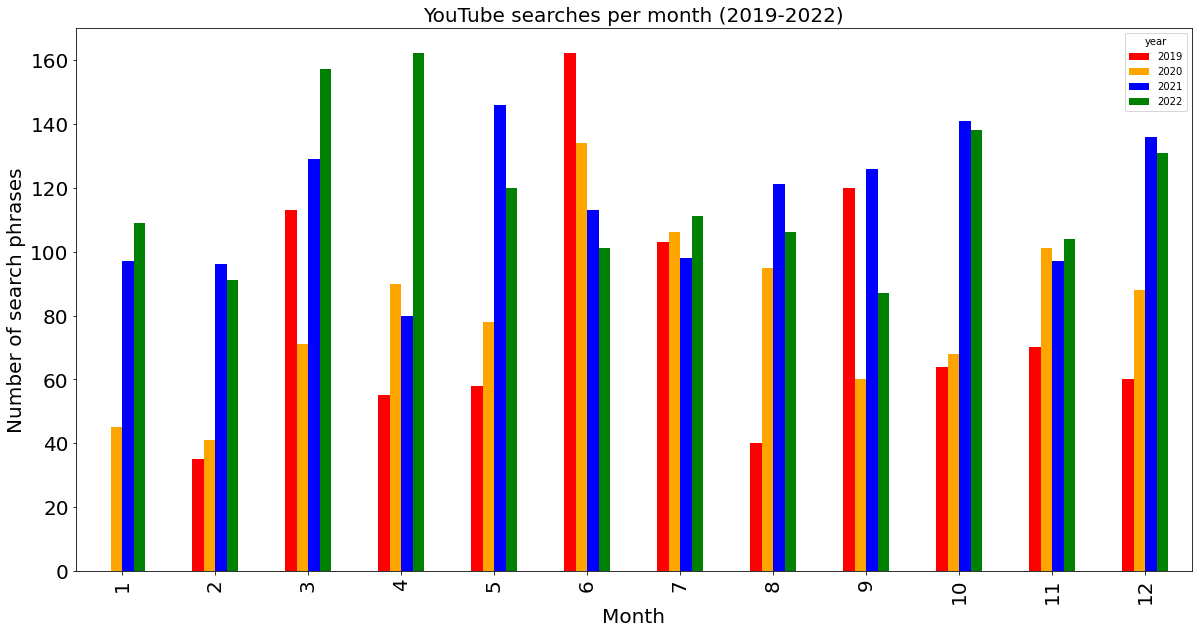

In [35]:
ax = counts.plot(kind='bar', color=['red', 'orange', 'blue', 'green'], figsize=(20, 10), fontsize=20)
plt.title('YouTube searches per month (2019-2022)', fontsize=20)
plt.xlabel('Month', fontsize=20)
plt.ylabel('Number of search phrases', fontsize=20)

### Word cloud

In [36]:
from wordcloud import WordCloud

# # define the text
# text = "This is a sample text with some words that will appear in the word cloud"

# # create a word cloud from the text
# wordcloud = WordCloud().generate(text)

# # display the word cloud
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()

- join every word that was searched into one string 

In [38]:
words = ' '.join(df_search_clean['phrase'])

- Generate Word Cloud

In [39]:
word_cloud = WordCloud(width = 1920, height = 1080,
                background_color ='black',
                min_font_size = 5).generate(words)

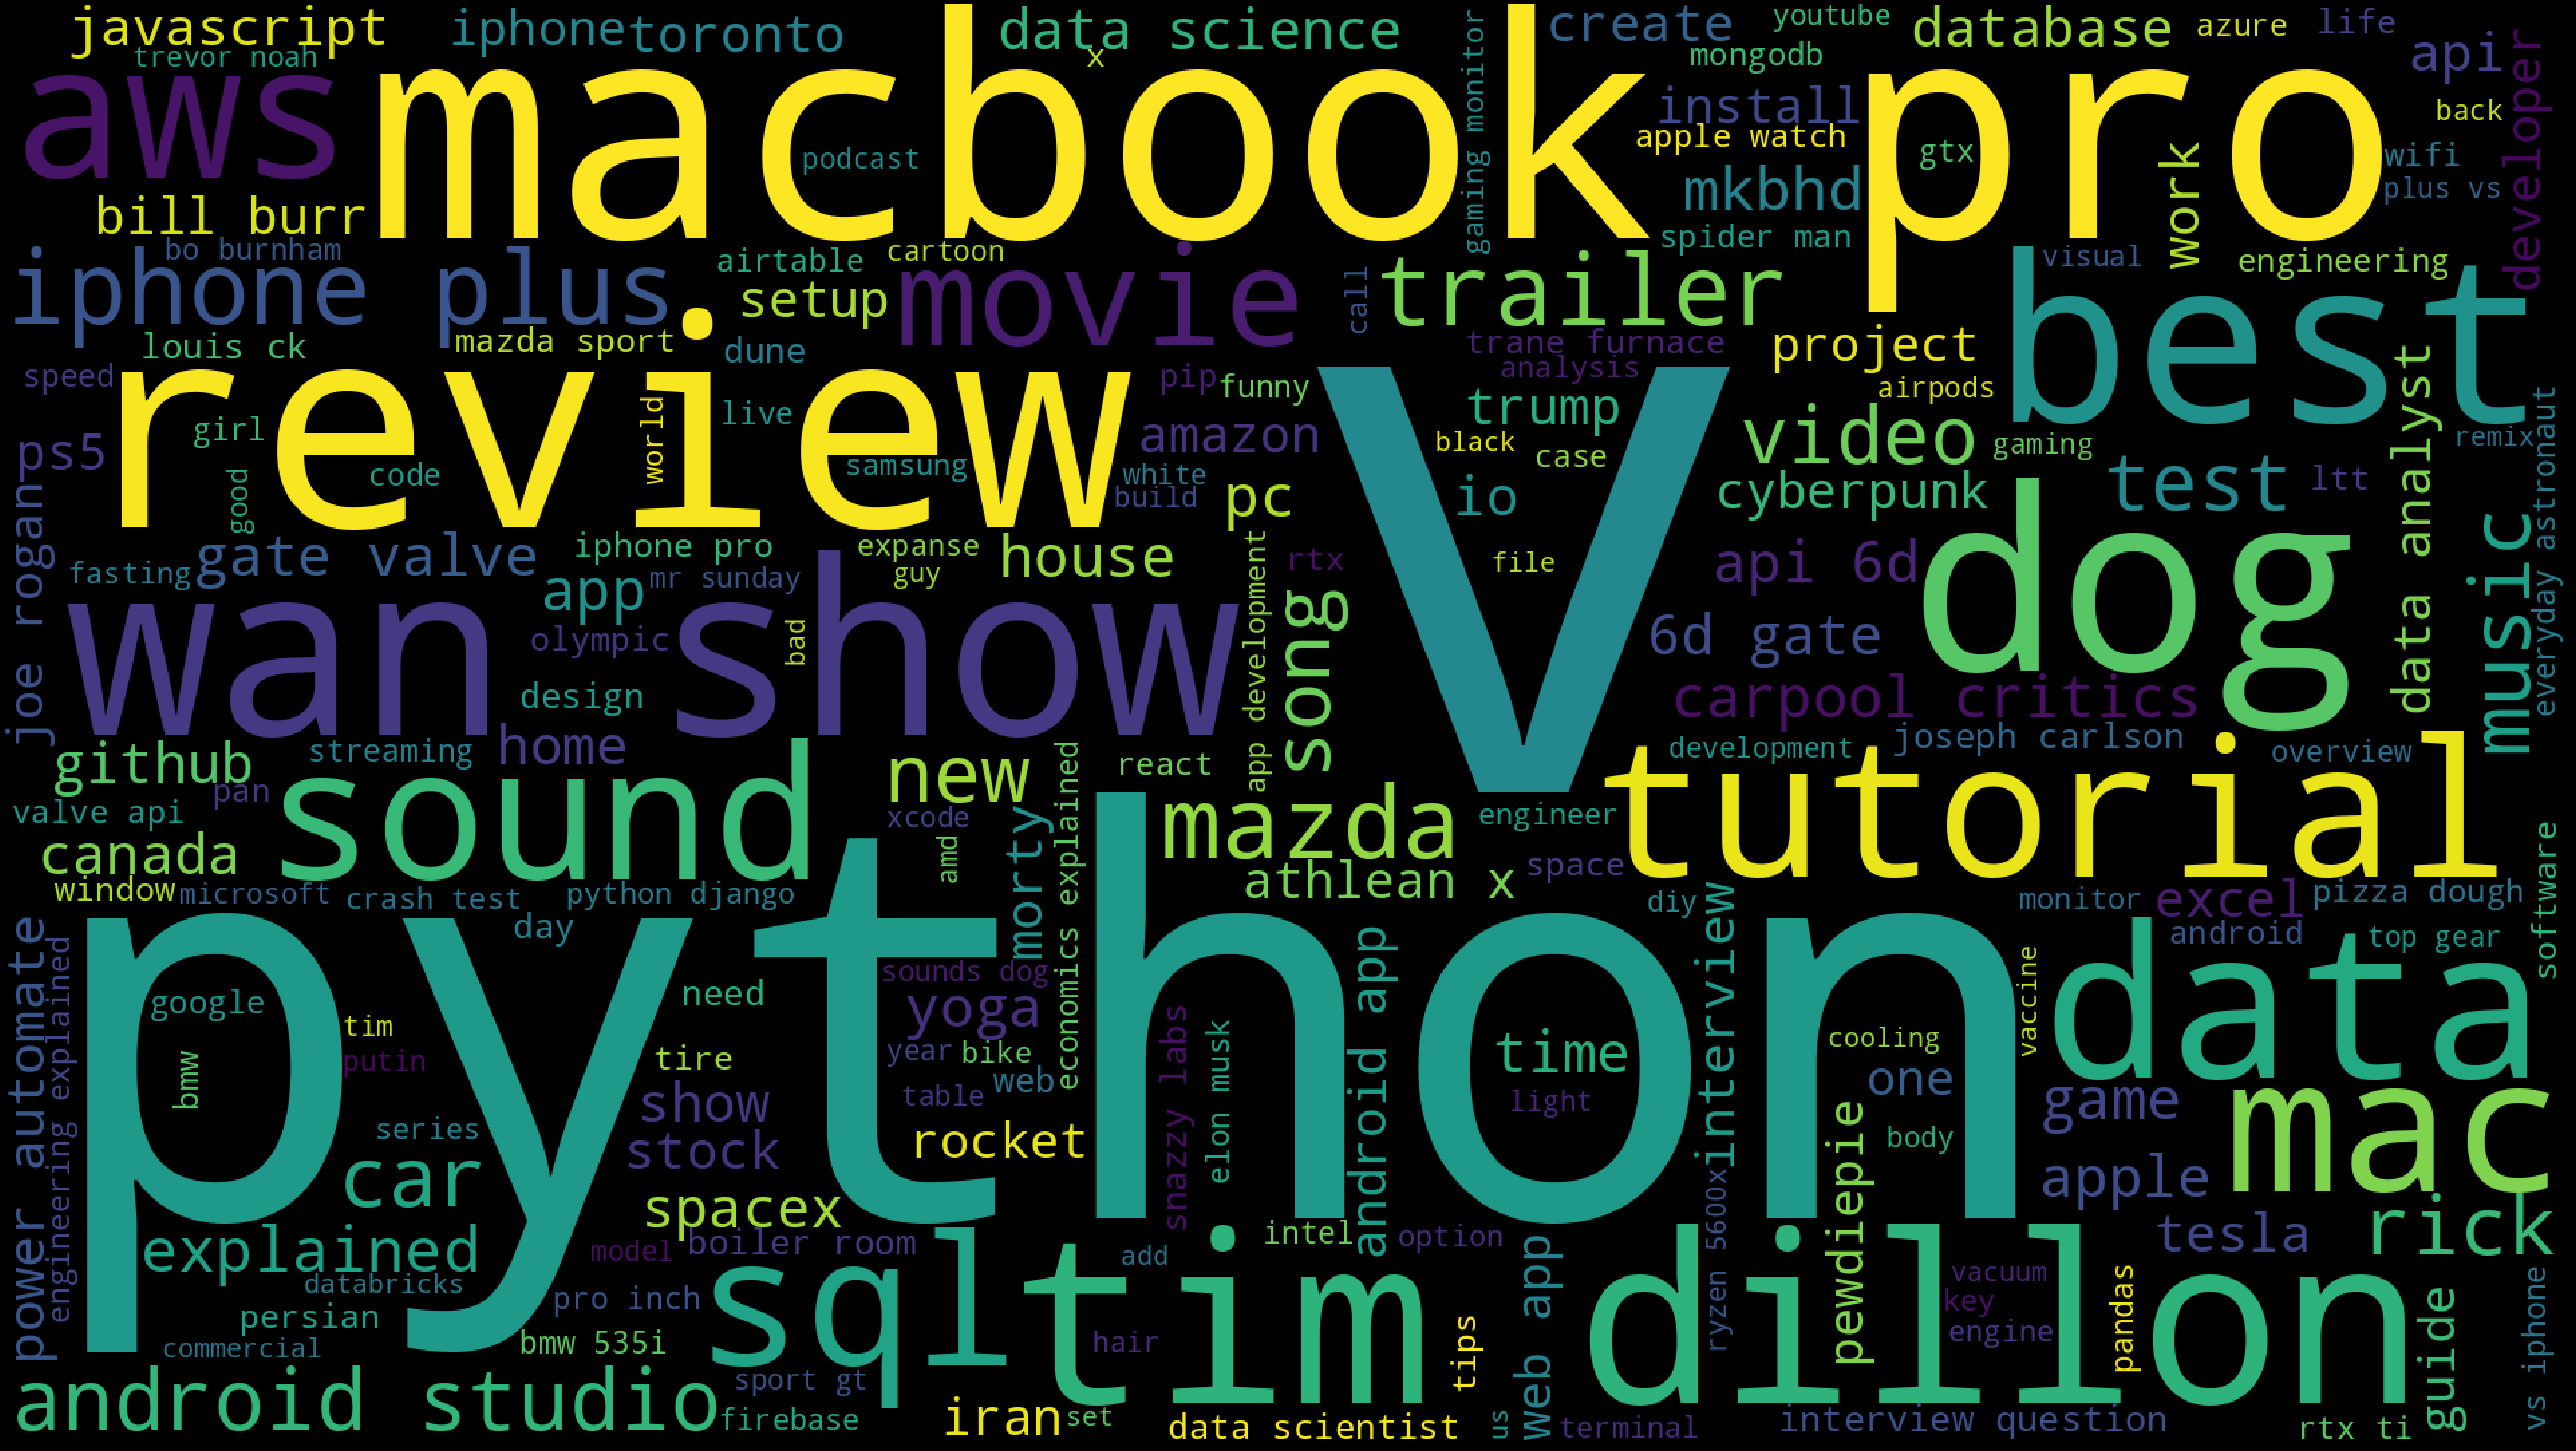

In [40]:
plt.figure(figsize = (100, 100), facecolor = 'black')
plt.imshow(word_cloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Watch history

### Read, parse, and clean watch history json file

- Watch history dataset is in a nested JSON format
- Using .json_normalize() to parse the nested objects

In [43]:
# Load the JSON file
with open(f"{path}/history/watch-history.json", 'r') as f:
    data = json.load(f)

# Initialize an empty list to store the parsed objects
parsed_objects = []

# Iterate over the objects in the JSON file
for obj in data:
    try:
        # Use json_normalize to parse the nested objects
        parsed = pd.json_normalize(obj, record_path='subtitles', meta=['header', 'title', 'titleUrl', 'time', 'products', 'activityControls'])
        parsed_objects.append(parsed)
    except KeyError:
        # some videos were removed and so they do not have the nested 'subtitles' object
        # If the 'subtitles' field is not present, skip the object
        continue

# Concatenate the parsed objects into a single dataframe
df_watch = pd.concat(parsed_objects)

df_watch = df_watch.rename(columns={'name': 'channel_name'})

In [44]:
df_watch.head()

,channel_name,url,header,title,titleUrl,time,products,activityControls
0,CondoWong,https://www.youtube.com/channel/UCbd2igYSbv2xR...,YouTube,"Watched My 3 Bold Predictions on Inflation, In...",https://www.youtube.com/watch?v=ZpEtSjWA2oo,2022-12-31T06:21:10.690Z,YouTube,YouTube watch history
0,Nando v Movies,https://www.youtube.com/channel/UCf29Sq6-XxLQG...,YouTube,Watched My Pitch for a Superman Reboot,https://www.youtube.com/watch?v=MVGW90cvC94,2022-12-31T05:39:10.809Z,YouTube,YouTube watch history
0,Outstanding Screenplays,https://www.youtube.com/channel/UCjdvPP6bIMctg...,YouTube,Watched How FAILURE was useful to Quentin Tara...,https://www.youtube.com/watch?v=NJP8MmkH1qc,2022-12-31T05:26:46.788Z,YouTube,YouTube watch history
0,Vsauce,https://www.youtube.com/channel/UC6nSFpj9HTCZ5...,YouTube,Watched The Topsy Turvy Top,https://www.youtube.com/watch?v=KWmaIZrBE2w,2022-12-31T05:26:15.468Z,YouTube,YouTube watch history
0,SciShow,https://www.youtube.com/channel/UCZYTClx2T1of7...,YouTube,"Watched Now, we can be as quiet as owls #short...",https://www.youtube.com/watch?v=1Dxn-1hSly8,2022-12-31T05:25:06.628Z,YouTube,YouTube watch history


- drop unnecessary columns

In [45]:
df_watch_clean = df_watch.drop(columns=['header', 'titleUrl', 'products', 'activityControls'])

- using the remove_words function from before, remove the word 'watched' from the title column to get the video title itself

In [46]:
df_watch_clean['title'] = df_watch_clean['title'].apply(remove_words, x=1)

In [89]:
df_watch_clean.head()

,channel_name,url,title,time,month,year
0,CondoWong,https://www.youtube.com/channel/UCbd2igYSbv2xR...,"My 3 Bold Predictions on Inflation, Interest R...",2022-12-31 06:21:10.690000+00:00,12,2022
0,Nando v Movies,https://www.youtube.com/channel/UCf29Sq6-XxLQG...,My Pitch for a Superman Reboot,2022-12-31 05:39:10.809000+00:00,12,2022
0,Outstanding Screenplays,https://www.youtube.com/channel/UCjdvPP6bIMctg...,How FAILURE was useful to Quentin Tarantino #s...,2022-12-31 05:26:46.788000+00:00,12,2022
0,Vsauce,https://www.youtube.com/channel/UC6nSFpj9HTCZ5...,The Topsy Turvy Top,2022-12-31 05:26:15.468000+00:00,12,2022
0,SciShow,https://www.youtube.com/channel/UCZYTClx2T1of7...,"Now, we can be as quiet as owls #shorts #scien...",2022-12-31 05:25:06.628000+00:00,12,2022


- remove identifiable data

In [90]:
df_watch_clean = df_watch_clean[df_watch_clean[['title', 'channel_name']].apply(lambda x: not any(word in x for word in text), axis=1)]

- convert the time column to datetime

In [91]:
df_watch_clean['time'] = pd.to_datetime(df_watch_clean['time'])

### Explore the data

In [92]:
df_watch_clean.head()

,channel_name,url,title,time,month,year
0,CondoWong,https://www.youtube.com/channel/UCbd2igYSbv2xR...,"My 3 Bold Predictions on Inflation, Interest R...",2022-12-31 06:21:10.690000+00:00,12,2022
0,Nando v Movies,https://www.youtube.com/channel/UCf29Sq6-XxLQG...,My Pitch for a Superman Reboot,2022-12-31 05:39:10.809000+00:00,12,2022
0,Outstanding Screenplays,https://www.youtube.com/channel/UCjdvPP6bIMctg...,How FAILURE was useful to Quentin Tarantino #s...,2022-12-31 05:26:46.788000+00:00,12,2022
0,Vsauce,https://www.youtube.com/channel/UC6nSFpj9HTCZ5...,The Topsy Turvy Top,2022-12-31 05:26:15.468000+00:00,12,2022
0,SciShow,https://www.youtube.com/channel/UCZYTClx2T1of7...,"Now, we can be as quiet as owls #shorts #scien...",2022-12-31 05:25:06.628000+00:00,12,2022


In [93]:
df_watch_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29564 entries, 0 to 0
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   channel_name  29564 non-null  object             
 1   url           29564 non-null  object             
 2   title         29564 non-null  object             
 3   time          29564 non-null  datetime64[ns, UTC]
 4   month         29564 non-null  int64              
 5   year          29564 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(2), object(3)
memory usage: 1.6+ MB


- create columns for month and year

In [94]:
df_watch_clean['month'] = pd.to_datetime(df_watch_clean['time']).dt.month
df_watch_clean['year'] = pd.to_datetime(df_watch_clean['time']).dt.year
df_watch_clean.head()

,channel_name,url,title,time,month,year
0,CondoWong,https://www.youtube.com/channel/UCbd2igYSbv2xR...,"My 3 Bold Predictions on Inflation, Interest R...",2022-12-31 06:21:10.690000+00:00,12,2022
0,Nando v Movies,https://www.youtube.com/channel/UCf29Sq6-XxLQG...,My Pitch for a Superman Reboot,2022-12-31 05:39:10.809000+00:00,12,2022
0,Outstanding Screenplays,https://www.youtube.com/channel/UCjdvPP6bIMctg...,How FAILURE was useful to Quentin Tarantino #s...,2022-12-31 05:26:46.788000+00:00,12,2022
0,Vsauce,https://www.youtube.com/channel/UC6nSFpj9HTCZ5...,The Topsy Turvy Top,2022-12-31 05:26:15.468000+00:00,12,2022
0,SciShow,https://www.youtube.com/channel/UCZYTClx2T1of7...,"Now, we can be as quiet as owls #shorts #scien...",2022-12-31 05:25:06.628000+00:00,12,2022


- create a column for month, and another for year

In [132]:
df_search_clean['month'] = pd.to_datetime(df_search_clean['time']).dt.month
df_search_clean['year'] = pd.to_datetime(df_search_clean['time']).dt.year

In [133]:
df_search_clean.head()

,time,phrase,month,year
0,2022-12-30 19:54:55.108000+00:00,home assistant docker cloud,12,2022
1,2022-12-30 19:54:49.003000+00:00,home assistant docker,12,2022
2,2022-12-30 09:21:54.192000+00:00,strangest places in game of thrones,12,2022
3,2022-12-30 07:20:07.337000+00:00,home assistant docker mac,12,2022
4,2022-12-30 07:19:52.519000+00:00,home assistant docker,12,2022


In [127]:
df_watch_clean_2022_count = df_watch_clean[df_watch_clean["time"].dt.year== 2022].groupby("channel_name").size().reset_index(name="count")
df_watch_clean_2021_count = df_watch_clean[df_watch_clean["time"].dt.year== 2021].groupby("channel_name").size().reset_index(name="count")
df_watch_clean_2020_count = df_watch_clean[df_watch_clean["time"].dt.year== 2020].groupby("channel_name").size().reset_index(name="count")
df_watch_clean_2019_count = df_watch_clean[df_watch_clean["time"].dt.year== 2019].groupby("channel_name").size().reset_index(name="count")

In [128]:
df_watch_clean_2022_count.sort_values(by="count", ascending=False).head(10)

,channel_name,count
1281,Linus Tech Tips,433
2122,TechLinked,189
1153,Joseph Carlson After Hours,121
1152,Joseph Carlson,116
1481,Mr Sunday Movies,108
634,Doctor Mike,105
1372,Marques Brownlee,105
2449,Waveform Clips,103
1677,PewDiePie,99
2362,Udacity,96


In [129]:
df_watch_clean_2021_count.sort_values(by="count", ascending=False).head(10)

,channel_name,count
1117,Linus Tech Tips,316
538,Donut Media,225
1288,Mr Sunday Movies,217
1834,TechLinked,161
1131,Louis Rossmann,152
550,Drew Gooden,120
1561,Reddit Studios,120
2052,Udacity,118
1188,Marques Brownlee,108
1236,Mia Plays,108


In [130]:
df_watch_clean_2020_count.sort_values(by="count", ascending=False).head(10)

,channel_name,count
643,Linus Tech Tips,308
1043,TechLinked,167
688,Marques Brownlee,143
177,CNBC,127
617,LMG Clips,124
655,LongBeachGriffy,119
343,Economics Explained,119
532,JRE Clips,110
301,Dave2D,88
840,PewDiePie,82


In [131]:
df_watch_clean_2019_count.sort_values(by="count", ascending=False).head(10)

,channel_name,count
776,TechLinked,125
480,Linus Tech Tips,94
507,Marques Brownlee,90
878,Vector,77
390,JRE Clips,64
614,PewDiePie,60
913,Wisecrack,56
488,LongBeachGriffy,55
460,LastWeekTonight,50
907,Wendover Productions,48


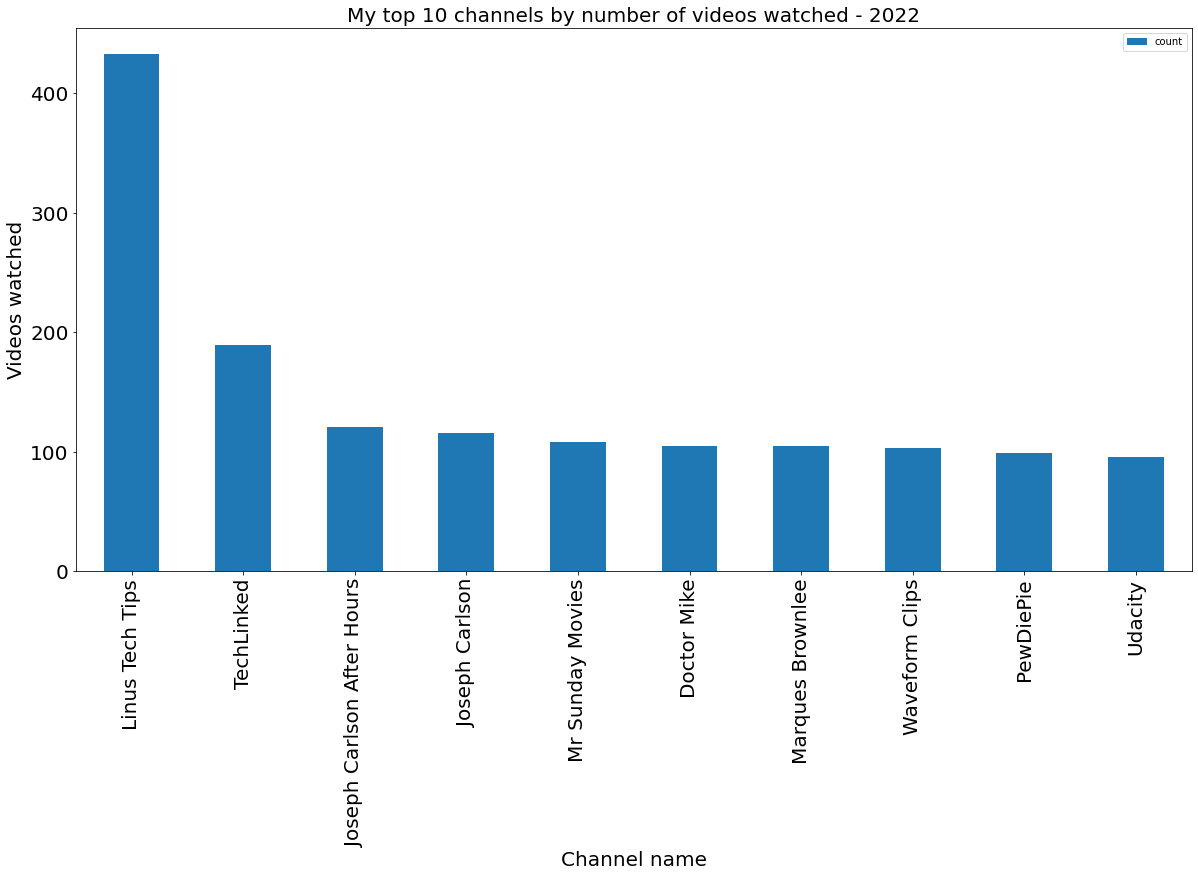

In [114]:
# plot bar chart of top ten channels by videos watched in 2022

df_watch_clean_2022_count.sort_values(by="count", ascending=False).head(10).plot(kind='bar', x='channel_name', y='count', figsize=(20, 10), fontsize=20)
plt.title("My top 10 channels by number of videos watched - 2022", fontsize=20)
plt.ylabel("Videos watched", fontsize=20)
plt.xlabel("Channel name", fontsize=20)

# show the plot
plt.show()

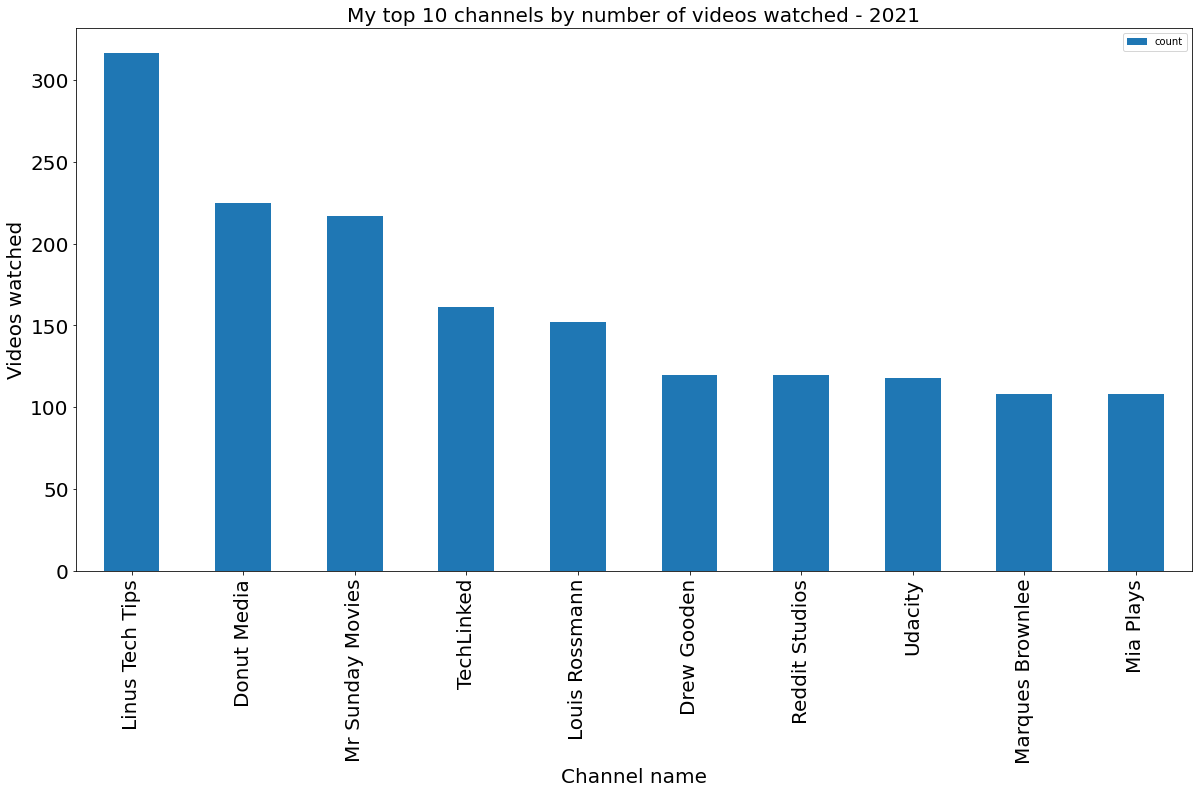

In [105]:
# plot bar chart of top ten channels by videos watched in 2021

df_watch_clean_2021_count.sort_values(by="count", ascending=False).head(10).plot(kind='bar', x='channel_name', y='count', figsize=(20, 10), fontsize=20)
plt.title("My top 10 channels by number of videos watched - 2021", fontsize=20)
plt.ylabel("Videos watched", fontsize=20)
plt.xlabel("Channel name", fontsize=20)

# show the plot
plt.show()

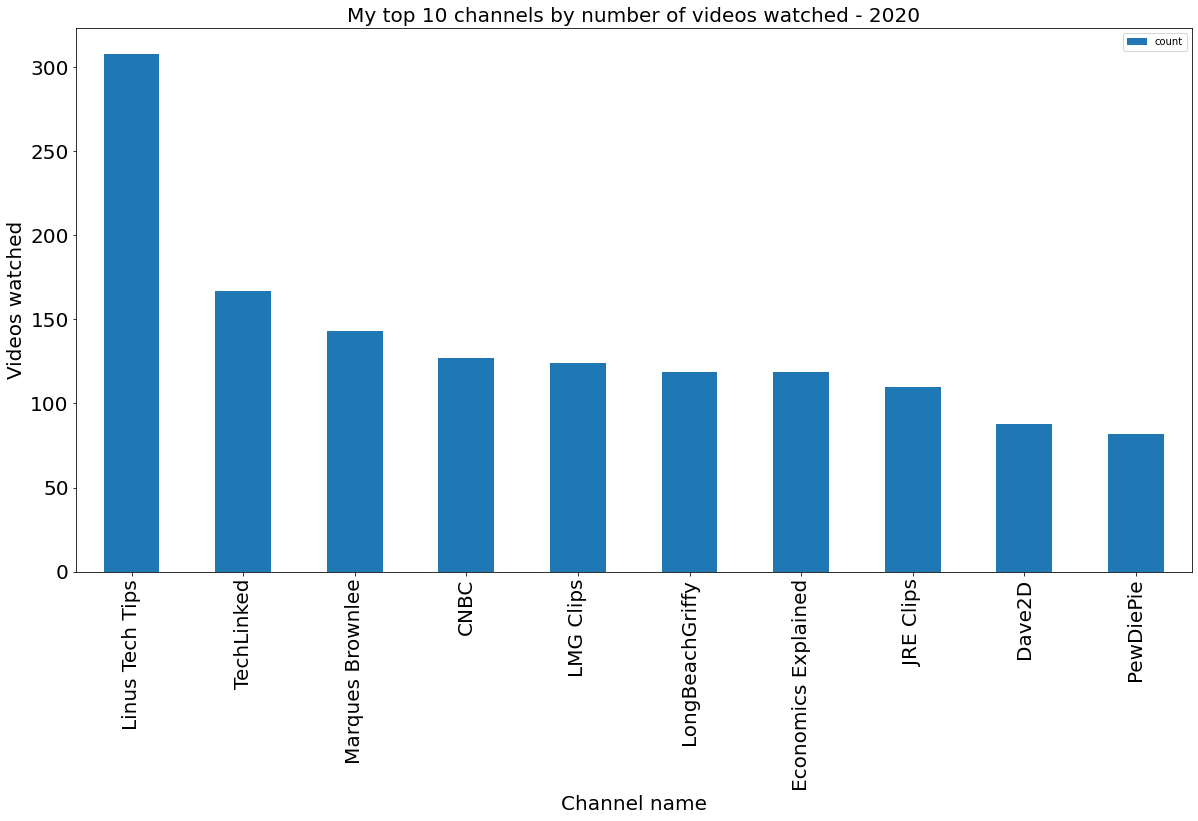

In [104]:
# plot bar chart of top ten channels by videos watched in 2020

df_watch_clean_2020_count.sort_values(by="count", ascending=False).head(10).plot(kind='bar', x='channel_name', y='count', figsize=(20, 10), fontsize=20)
plt.title("My top 10 channels by number of videos watched - 2020", fontsize=20)
plt.ylabel("Videos watched", fontsize=20)
plt.xlabel("Channel name", fontsize=20)

# show the plot
plt.show()

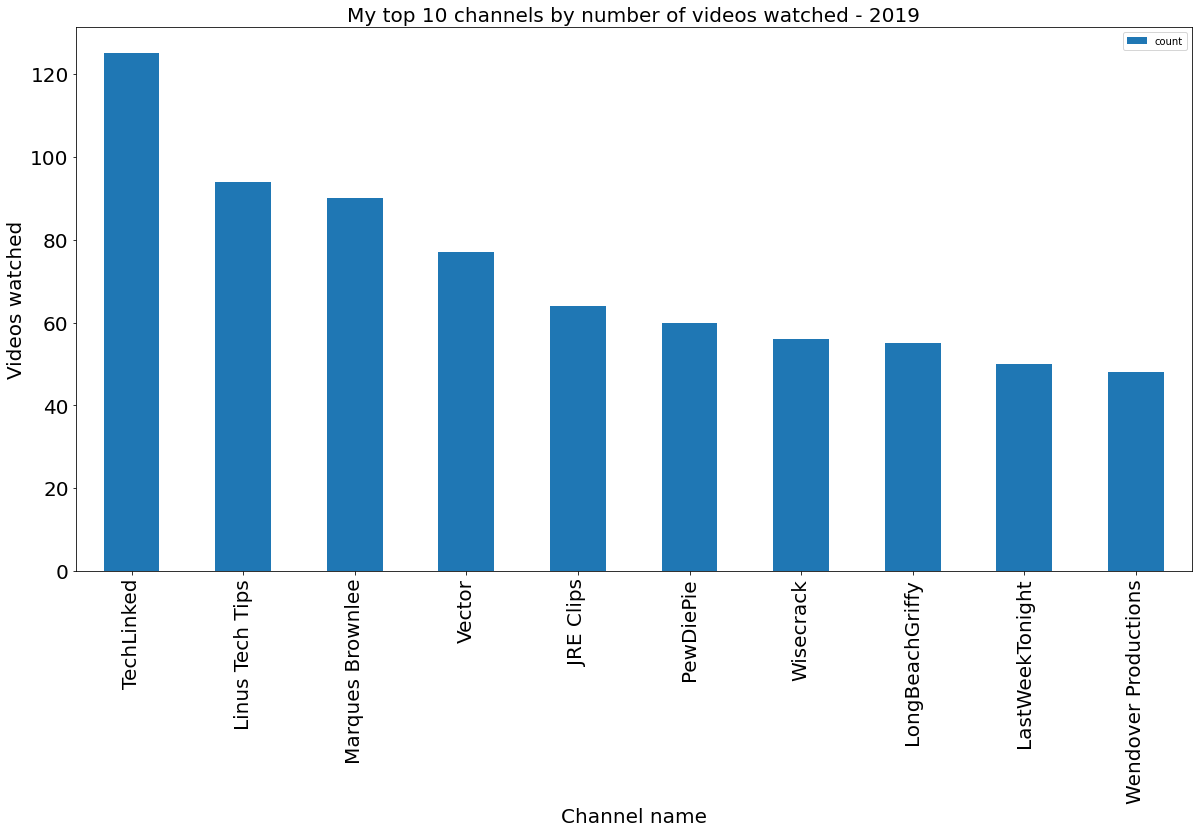

In [103]:
# plot bar chart of top ten channels by videos watched in 2019

df_watch_clean_2019_count.sort_values(by="count", ascending=False).head(10).plot(kind='bar', x='channel_name', y='count', figsize=(20, 10), fontsize=20)
plt.title("My top 10 channels by number of videos watched - 2019", fontsize=20)
plt.ylabel("Videos watched", fontsize=20)
plt.xlabel("Channel name", fontsize=20)

# show the plot
plt.show()

# Subscriptions

### Read the data

In [52]:
df_subs = pd.read_csv(f"{path}/subscriptions/subscriptions.csv")
# df_comments = pd.read_html(f"{path}/my-comments/my-comments.csv")